In [ ]:
import os
import time
import requests
from lxml import etree
import pandas as pd
from bs4 import BeautifulSoup
import random
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
import re
import csv
import json
import requests
import random
import os
import time

In [2]:
headers = {
  "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
  "Accept-Language": "zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6",
  "Cache-Control": "max-age=0",
  "Connection": "keep-alive",
  "Referer": "https://www.dianping.com/shenzhen/ch10/o3",
  "Sec-Fetch-Dest": "document",
  "Sec-Fetch-Mode": "navigate",
  "Sec-Fetch-Site": "same-origin",
  "Sec-Fetch-User": "?1",
  "Upgrade-Insecure-Requests": "1",
  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 Edg/123.0.0.0",
  "sec-ch-ua-mobile": "?0"
}

cookies={
  "navCtgScroll": "0",
  "_lxsdk_cuid": "18e69f73b3dc8-0227d3fb55f1c6-4c657b58-13c680-18e69f73b3dc8",
  "_lxsdk": "18e69f73b3dc8-0227d3fb55f1c6-4c657b58-13c680-18e69f73b3dc8",
  "_hc.v": "315e914a-da94-23ba-5ee7-d53b7be2e520.1711176105",
  "WEBDFPID": "9yx82v5yx0v851uzz64wy62022194z2281v3z9y492x97958vw654zxv-2026536109663-1711176109663YISQUWGfd79fef3d01d5e9aadc18ccd4d0c95072601",
  "ua": "%E7%82%B9%E5%B0%8F%E8%AF%848793679062",
  "ctu": "b764f0d09af3d6815ec1347f5abe8697c5387a09b46bab9327703cec4d39bdc8",
  "s_ViewType": "10",
  "qruuid": "0b8d838c-4b3f-4d54-9eb6-2863a3f15679",
  "dplet": "0ba10c2857ffd52cd771064c402fb4e8",
  "dper": "0202b01e7f9a90c41ceaabcd955e2a2dba4a1c97b376e355c153c7aece0f3ad87a018143a7301912c5ccc1ee9d88b9ed0a536c3deb711fe68acd000000004f1f00003253c1430f99030e9b0c92660d391f86c4bf11502214c00a81db964d0b5574ea82f96a2c5e417cfce44522a57b1304f6",
  "fspop": "test",
  "_lx_utm": "utm_source%3Dbing%26utm_medium%3Dorganic",
  "ll": "7fd06e815b796be3df069dec7836c3df",
  "Hm_lvt_602b80cf8079ae6591966cc70a3940e7": "1712806317,1712980126,1713061776,1713352241",
  "cy": "7",
  "cye": "shenzhen",
  "Hm_lpvt_602b80cf8079ae6591966cc70a3940e7": "1713352262",
  "_lxsdk_s": "18eebc06dd7-0c8-c96-0cd%7C%7C118"
}

In [ ]:
def save_progress(zy_i, page, index):
    """保存第page页，第index条的数据到progress文件中"""
    with open('大众点评progress.txt', 'w') as file:
        file.write(f'{zy_i},{page},{index}')


def load_progress():
    if os.path.exists('大众点评progress.txt'):
        with open('大众点评progress.txt', 'r') as file:
            """如果读到文件中保留的信息，就读取对应的数据"""
            progress = file.read().strip().split(',')
            if len(progress) == 3:
                return int(progress[0]), int(progress[1]), int(progress[2])
    return 1, 1, 1

def crawl(url):
    """分析主页面提取对应的菜系名单"""
    response = requests.get(url=url, cookies=cookies, headers=headers)
    content = response.text
    txt = etree.HTML(content)
    start_cx, start_page, start_index = load_progress()
    print(start_cx, start_page, start_index)
    
    for i in range(start_cx, 37):
        name = txt.xpath(f'//*[@id="classfy"]/a[{i}]/span/text()')[0]
        print(f"当前正在爬取{name}")
        fl = txt.xpath(f'//*[@id="classfy"]/a[{i}]/@href')[0]
        List_index(fl, i, start_page, start_index)
        
        start_page=1

def List_index(fl, start_cx, start_page, start_index):
    """对每个菜系进行拆解，该函数需要传入每一个菜系的链接，编号，每一页的开始，每一条的开始，方便持久化"""
    www = []
    for page in range(start_page, 51):
        fl = fl + f'p{page}'
        response1 = requests.get(url=fl, cookies=cookies, headers=headers, timeout=20)  
        time.sleep(2)
        content1 = response1.text
        txt1 = etree.HTML(content1)
        for a in range(start_index, 16):
            w = Data_analysis(txt1, a, page)
            www.append(w)
            down_load(www)
            www.clear()
            time.sleep(random.uniform(1,2))
            save_progress(start_cx, page, a + 1)
        start_index=1

def Data_analysis(txt1, a, page):
    """解析详细数据页面"""
    try:
        Restaurant_name = txt1.xpath(f'//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[1]/a/h4/text()')[0]  # 店铺名称
    except Exception as e:
        Restaurant_name = "NULL"

    try:
        pj_count = txt1.xpath(f'//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[2]/a[1]/b/text()')[0]  # 评论数量
        pj_count = pj_count + " 条评论"
    except Exception as e:
        pj_count = "NULL"

    try:
        per_price = txt1.xpath(f'//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[2]/a[2]/b/text()')[0]  # 人均消费
        per_price = "人均 " + per_price
    except Exception as e:
        per_price = "NULL"

    try:
        main_shell = txt1.xpath(f'//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[3]/a[1]/span/text()')[0]  # 售卖主食
    except Exception as e:
        main_shell = "NULL"

    try:
        Business_district = txt1.xpath(f'//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[3]/a[2]/span/text()')[0]  # 商圈信息
    except Exception as e:
        Business_district = "NULL"

    try:
        Recommended_dish = txt1.xpath(f'string(//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[4])')  # 推荐菜系
        tjc = remove_newlines(Recommended_dish)
        qwer = convert_list_to_string(tjc)
    except Exception as e:
        qwer = "NULL"
    try:
        Tg = txt1.xpath(f'string(//*[@id="shop-all-list"]/ul/li[{a}]/div[3]/div)')  # 团购
        Tg1 = remove_newlines(Tg)
        Tg2 = convert_list_to_string(Tg1)
    except  Exception as e:
        Tg2 = 'NULL'

    try:
        Detailed_link = txt1.xpath(f'//*[@id="shop-all-list"]/ul/li[{a}]/div[2]/div[1]/a/@href')[0]  # 详情链接
    except Exception as e:
        Detailed_link = "NULL"
    w = [Restaurant_name, pj_count, per_price, main_shell, Business_district, qwer, Tg2, Detailed_link]
    print(f'第{page}页第{a}条', w)
    return w

def remove_newlines(text):
    """去掉换行符"""
    return [dish.strip() for dish in text.split(" ") if dish != ""]

def convert_list_to_string(list_data):
    """字符串拼接"""
    return "、".join([dish for dish in list_data if dish != ""])

def down_load(wkb):
    columns = ['店铺名称', '评论数量', '人均消费', '售卖主食', '商圈信息', '推荐菜系', '团购', '详情链接']
    df = pd.DataFrame(wkb, columns=columns)
    file_exists = os.path.isfile('大众点评1.csv')
    
    with open('大众点评1.csv', 'a', newline='', encoding='utf-8-sig') as f:
        df.to_csv(f, header=not file_exists, index=False, mode='a', encoding='utf-8-sig') 

if __name__ == '__main__':
    url = 'https://www.dianping.com/shenzhen/ch10'
    crawl(url)

36 50 16
当前正在爬取中东菜


In [2]:
import time
from lxml import etree
import requests
# import cx_Oracle as cx
import random

In [112]:
cookies={
  "fspop": "test",
  "_lxsdk_cuid": "18e840a0078c8-0b7c5e936ea987-26001a51-13c680-18e840a0079c8",
  "_lxsdk": "18e840a0078c8-0b7c5e936ea987-26001a51-13c680-18e840a0079c8",
  "_hc.v": "b7d45eeb-9188-2a9a-c0f7-c87565145657.1711612232",
  "Hm_lvt_602b80cf8079ae6591966cc70a3940e7": "1711612233",
  "_lx_utm": "utm_source%3DBaidu%26utm_medium%3Dorganic",
  "cy": "8",
  "cye": "chengdu",
  "s_ViewType": "10",
  "WEBDFPID": "0x48z3z89w105y38058yz2z4v6y5848381v159zxx8w9795889y17x70-2026972283301-1711612283301CQKOGWSfd79fef3d01d5e9aadc18ccd4d0c95073548",
  "qruuid": "cd3accca-81a9-42b2-bc20-41910e373511",
  "dplet": "cee45729a031b16a47ec53b438264d99",
  "dper": "0202d024488a8139cda0049f04c8c1cac1c70bd70caaf0fc47021f8cdf5ce05b5ad7f1c129c442a404faa02b58a8b795cbe55d58fba9f9daa9b000000000fa1e00002ad66f0acd459cc5c8e0321f54965ceba20c0268d771e7d54841115d167e36d7c1b04d85b97b70938f9d84259a76b1ad",
  "ll": "7fd06e815b796be3df069dec7836c3df",
  "ua": "%E7%82%B9%E5%B0%8F%E8%AF%848793679062",
  "ctu": "b764f0d09af3d6815ec1347f5abe8697a733ac86ed70e90757f954c1c642f2d0",
  "Hm_lpvt_602b80cf8079ae6591966cc70a3940e7": "1711612479",
  "_lxsdk_s": "18e840a0079-400-0f9-384%7C%7C432"
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6',
    'Cache-Control': 'no-cache',
    'Connection': 'keep-alive',
    'Referer': 'https://www.dianping.com/',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36 Edg/115.0.1901.203',
    'sec-ch-ua': '"Not/A)Brand";v="99", "Microsoft Edge";v="115", "Chromium";v="115"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

In [ ]:
def index_load(url, shop_name):
    response = requests.get(url=url, headers=headers, cookies=cookies)

    if response.status_code == 200:
        content = response.text
        text = etree.HTML(content)
        try:
            xq_score = text.xpath('string(//*[@id="comment_score"])')  # 详情打分
        except Exception as e:
            xq_score = '无'
        try:
            phone = text.xpath('string(//*[@id="basic-info"]/p)')  # 电话
        except Exception as e:
            phone = '无'
        try:
            dz = text.xpath('//*[@id="address"]/text()')[0]  # 地址
        except Exception as e:
            dz = '无'
        try:
            bm = text.xpath('//*[@id="basic-info"]/div[4]/p[1]/span[2]/text()')[0]  # 别名
        except Exception as e:
            bm = '无'
        try:
            yysj = text.xpath('//*[@id="basic-info"]/div[4]/p[2]/span[2]/text()')[0]  # 营业时间
        except Exception as e:
            yysj = '无'
        data = {
            '店铺名': shop_name,
            '详情打分': xq_score,
            '电话': phone,
            '地址': dz,
            '别名': bm,
            '营业时间': yysj,
        }
        return data
    else:
        print(response.text)
        return 0

def down_load(data):
    columns = ['店铺名', '详情打分', '电话', '地址', '别名', '营业时间']
    df = pd.DataFrame(data, columns=columns)
    
    file_path = '大众点评_详情.csv'
    file_exists = os.path.isfile(file_path)
    
    with open(file_path, 'a', newline='', encoding='utf-8') as f:
        df.to_csv(f, header=not file_exists, index=False, mode='a', encoding='utf-8')  # 添加而不是覆盖

def main():
    df = pd.read_excel('处理后的大众点评.xlsx')
    df_xq_for = df["详情链接"].iloc[372:]
    df_shop_name = df["店铺名"].iloc[372:]
    all_data = []
    count = 0

    for i, shop_name in zip(df_xq_for, df_shop_name):
        time.sleep(random.uniform(5, 7))
        data = index_load(i, shop_name)
        all_data.append(data) 
        down_load([data])
        print(shop_name)

    print("爬取完成")

if __name__ == "__main__":
    main()

嗨岛兔·四川特产烤兔兔头(中坝店)
嗨岛兔四川特产烤兔烤鸡兔头(绿地468店)
海底捞火锅(成都大悦城店)
海底捞火锅(春熙路群光广场店)
海底捞火锅(金牛凯德店)
海底捞火锅(凯德天府店)
海底捞火锅(龙湖三千集店)
海底捞火锅(七一国际广场店)
海底捞火锅(仁和新城店)
海底捞火锅(世豪广场店)
海底捞火锅(王府井店)
海底捞火锅(新光天地店)
海底捞火锅(旭海广场店)
海底捞火锅(阳光新业店)
海法Viva house(三圣乡店)
海椒市落舌·非遗手工冒菜(建设路店)
海椒市落舌·麻辣烫冒菜(晶融汇店)
海南风情·中餐家宴·柴火鸡(三圣乡店)
韩包子(建设路店)
韩国小胖自助烤肉(总店)
韩味宫烤肉和牛品鉴(西村店)
汉堡王(成都百脑汇店)
汉堡王(成都大悦城店)
汉堡王(成都鸿云悦街店)
汉堡王(成都双铁路店)
汉堡王(成都银泰中心)
汉堡王(富力广场店)
汉堡王(恒大广场店)
汉堡王(华熙店)
汉堡王(华宇店)
汉堡王(解放北路店)
汉堡王(金牛区欢乐谷店)
汉堡王(龙湖滨江天街店)
汉堡王(青羊万达店)
汉堡王(银海中心店)
汉堡王(银泰城店)
汉堡王(优客广场店)
蚝英雄·自助烤蚝(高新店)
豪虾传龙虾馆(春熙路太古里总店)
好又来招牌酸辣粉(银石广场店)
好又香串串(石人南路100号院店)
禾风·海鲜料理自助(人民南路店)
合盛小面(金沙店)
合一简串串(红建路店)
何坪舅舅街市火锅(玉林店)
何小欢·南充方锅盔
和联潮汕牛肉火锅(总府路店)
贺记蛋烘糕(青羊第五分店)
贺水饺
黑豆花养生汤锅(温泉正街店)
黑竹香鸡(营和巷店)
恒运捞月火锅(龙泉总店)
红辣椒·川菜·火锅(科华路店)
红辣椒·川菜·火锅(科华路店)
红社老火锅(双桥社区店)
红虾社·江湖菜大牌档(太古里店)
红星兔丁(武侯祠店)
红星兔丁(西门店)
红杏酒家(锦华店)
红杏酒家(锦苑店)
红忆火锅(玉锦店)
洪七公吃串串(总府路直营店)
鸿社麻辣烫(天府新区总店)
鸿运兔·手撕烤兔(天府广场店)
吼堂老火锅(太古里总店)
厚旦吐司Hold On Toast(贝森路店)
呼哈鸡汤铺子(万象城店)
胡成记口蘑龙眼包子(盐道街店)
胡二哥药膳蹄花
胡鸡肉(银沙北街店)
胡记串串香(星辉店)
胡记蛋烘糕小蛋糕(五桂苑店)
胡世羊肉汤(南街店)
胡桃里音乐餐酒馆·新派宴会·年会团建·派对场地

In [3]:
data = pd.read_excel('处理后的大众点评.xlsx')
data

,店铺名,评论,综合评分,消费,主食,商圈地点,推荐菜,团购,口味,环境,服务,电话,地址,营业时间,详情链接
0,1984内江老味道小吃店(清凤店),595.0,8.144884,16.0,小吃,伊藤/世豪广场,泡椒牛肉面 麻辣豆腐脑 麻辣热凉粉,NaN,7.8,7.5,7.7,18980709845,荣华北路69号4栋附114号,周一至周日,https://www.dianping.com/shop/ipXJWqKMTvEgHcYi
1,1985牛市口番茄煎蛋面(泰合·国际财富中心店),1286.0,8.000000,18.0,面馆,牛市口,牛市口番茄鸡蛋面 泡菜 粉蒸牛肉,NaN,8,8,8.0,18583731120,通宝街19号（牛市口地铁站A1口步行310米）,周一至周日,https://www.dianping.com/shop/H1NxNvZNeJ660kqh
2,1道肥肠(国光十街坊店),1808.0,8.503564,18.0,快餐简餐,建设路/电子科技大学,铁板烧肥肠 年糕 洋葱,NaN,7.7,7.4,7.5,13880305060,建设巷12附7号,周一至周日,https://www.dianping.com/shop/kaATurboWGe4Pn4U
3,313羊庄(高新店),556.0,8.003494,126.0,牛羊肉火锅,新街里,羊肉大串 养生锅底 蘸料,更多3单团购、团购：313羊庄!仅售95元！价值100元的代金券1张，仅适用于菜品，可叠加使...,8,7.8,7.7,028-61533567,荟锦路102号,周一至周日,https://www.dianping.com/shop/H6qpWAjON8sRwPzP
4,65号麻辣烫,110.0,7.825611,91.0,小吃快餐,郫筒,麻辣牛肉 卤豆丝 毛肚,NaN,7.6,7.5,7.5,18010658705,一环路西北段65号,周一至周日,https://www.dianping.com/shop/k8oiu1MmM9vJr85N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9182,王氏笋子面,80.0,8.592639,12.0,粉面馆,温江区,笋子面,NaN,8.2,7.6,7.5,NaN,NaN,NaN,https://www.dianping.com/shop/H2lU5KZtVOxK5MsQ
9183,白家高记肥肠粉(华阳店),1199.0,8.967511,21.0,肥肠粉,华阳,冒节子肥肠粉 锅盔 红汤肥肠粉,NaN,8.1,9.2,8.8,NaN,NaN,NaN,https://www.dianping.com/shop/l78TdKrqbRWtCsks
9184,秦记一品扯面(温江店),486.0,8.805757,27.0,粉面馆,柳浪湾,小煎鸡拌面 油泼面 开胃鸡杂面,NaN,7.6,8.9,8.9,NaN,NaN,NaN,https://www.dianping.com/shop/H6YtL09rTRfbQiUy
9185,老南充米粉(理想中心店),149.0,9.800989,17.0,米线,九方购物中心,麻辣牛肉米粉 肥肠米粉 麻辣黄鳝米粉,NaN,9.1,8.9,8.9,NaN,NaN,NaN,https://www.dianping.com/shop/k3VLVsLG2g2H6HBu


In [ ]:
df = data.copy()
rows_before = df.shape[0]
df_cleaned = df.dropna(subset=['店铺名', '评论', '消费', '主食', '商圈地点'])
rows_after = df_cleaned.shape[0]

rows_changed = rows_before - rows_after

print("清理前的行数:", rows_before)
print("清理后的行数:", rows_after)
print("行数的变化:", rows_changed)

清理前的行数: 9187
清理后的行数: 7989
行数的变化: 1198


各列的空值情况:
店铺名        0
评论       546
综合评分       2
消费      1077
主食         0
商圈地点      17
推荐菜     1786
团购      3617
口味         0
环境         0
服务         2
电话      8570
地址      8568
营业时间    8600
详情链接       0
dtype: int64


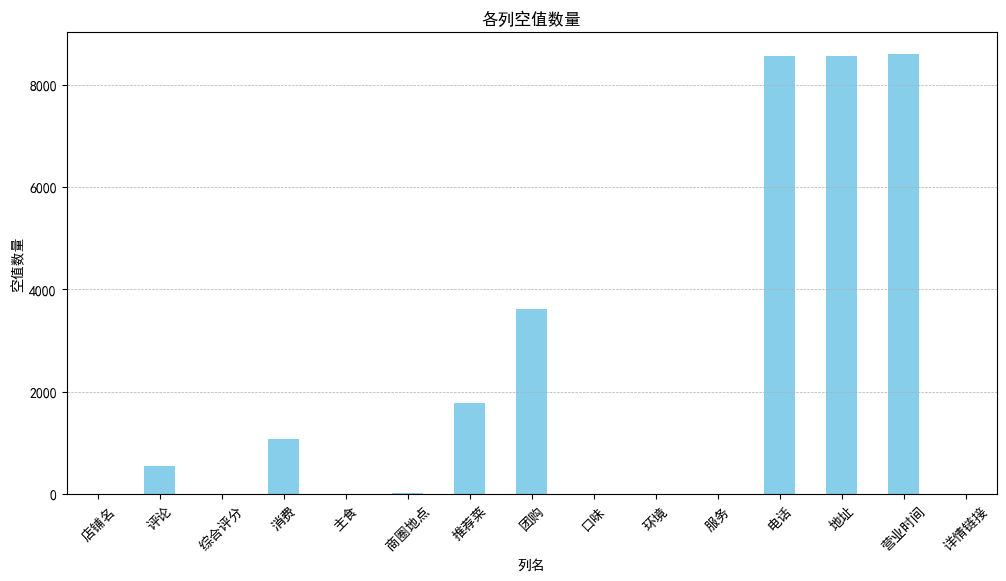

In [ ]:
missing_values = df.isnull().sum()
print("各列的空值情况:")
print(missing_values)

plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('各列空值数量')
plt.xlabel('列名')
plt.ylabel('空值数量')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
print("去重前行数：", df.shape[0])

df = df.drop_duplicates(subset=['店铺名'])

print("去重后行数：", df.shape[0])

去重前行数： 9187
去重后行数： 8480


In [ ]:
df[['消费', '口味', '环境', '服务']] = df[['消费', '口味', '环境', '服务']].apply(pd.to_numeric, errors='coerce')
columns_of_interest = ['消费', '口味', '环境', '服务']

statistics = df[columns_of_interest].describe()

print("描述性统计结果:")
print(statistics)

描述性统计结果:
                消费           口味           环境           服务
count  7452.000000  8478.000000  8478.000000  8478.000000
mean     72.309179     8.106369     8.101368     8.110793
std     115.107512     0.619160     0.631778     0.629059
min       3.000000     7.000000     6.300000     6.800000
25%      34.000000     7.600000     7.600000     7.600000
50%      57.000000     8.100000     8.100000     8.100000
75%      82.000000     8.600000     8.600000     8.600000
max    5847.000000     9.200000     9.200000     9.200000


描述性统计结果:
                消费           口味           环境           服务
count  7452.000000  8478.000000  8478.000000  8478.000000
mean     72.309179     8.106369     8.101368     8.110793
std     115.107512     0.619160     0.631778     0.629059
min       3.000000     7.000000     6.300000     6.800000
25%      34.000000     7.600000     7.600000     7.600000
50%      57.000000     8.100000     8.100000     8.100000
75%      82.000000     8.600000     8.600000     8.600000
max    5847.000000     9.200000     9.200000     9.200000


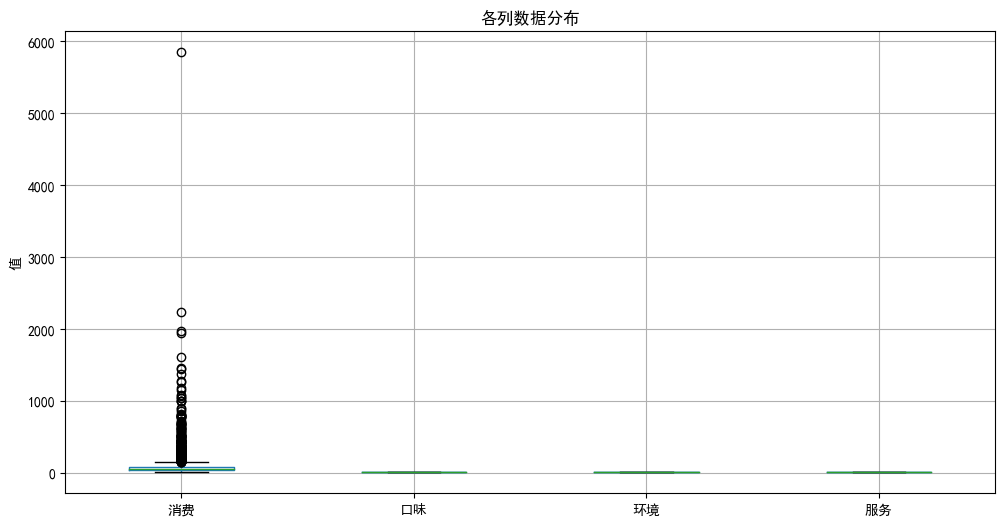

In [ ]:
columns_of_interest = ['消费', '团购', '口味', '环境', '服务']

statistics = df[columns_of_interest].describe()

print("描述性统计结果:")
print(statistics)

plt.figure(figsize=(12, 6))
df[columns_of_interest].boxplot()
plt.title('各列数据分布')
plt.ylabel('值')
plt.show()

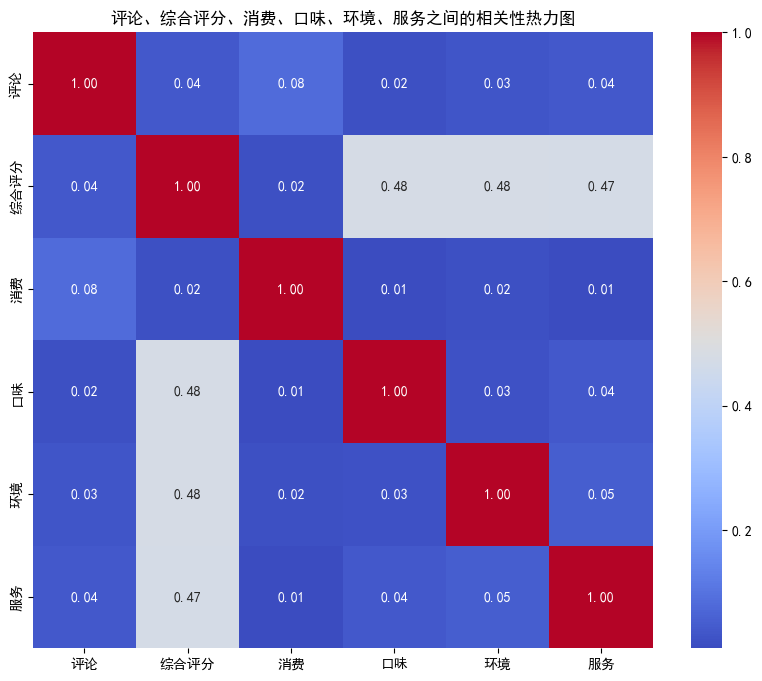

In [ ]:
import seaborn as sns
correlation_matrix = df[['评论','综合评分','消费', '口味', '环境', '服务']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('评论、综合评分、消费、口味、环境、服务之间的相关性热力图')
plt.show()

In [ ]:
top_10_df = df.nlargest(10, '评论')

result_df = []

for index, row in top_10_df.iterrows():
    comment_count = row['评论']
    main_food_preference = row['主食']
    result_df.append((row['店铺名'], comment_count, main_food_preference))

result_df = pd.DataFrame(result_df, columns=['店铺名', '评论', '主食'])
result_df

,店铺名,评论,主食
0,芭菲盛宴·环球美食(锦城万达广场店),32893.0,自助餐
1,汉丽轩韩式自助烤肉(SM店),28475.0,烤肉自助
2,烤匠麻辣烤鱼(春熙路群光广场店),25559.0,烤鱼
3,小龙坎火锅(全球旗舰店),25138.0,四川火锅
4,嘉州叶婆婆钵钵鸡(太古里店),24237.0,钵钵鸡
5,小龙坎火锅(春熙太古里店),22478.0,四川火锅
6,烤匠麻辣烤鱼(IFS店),22226.0,烤鱼
7,西月城谭豆花(春熙路店),20984.0,豆花
8,吼堂老火锅(太古里总店),20754.0,四川火锅
9,蜀大侠火锅(春熙店),19890.0,火锅


       主食         评论        占比
23    川菜馆  1367566.0  0.166968
14   四川火锅   805676.0  0.098366
3     串串香   515483.0  0.062936
102  面包烘焙   380077.0  0.046404
82    自助餐   316828.0  0.038682
..    ...        ...       ...
15    家常菜      171.0  0.000021
92   西式正餐       95.0  0.000012
51   火锅自助       53.0  0.000006
27   快餐自助       42.0  0.000005
97   轻食沙拉       33.0  0.000004

[113 rows x 3 columns]


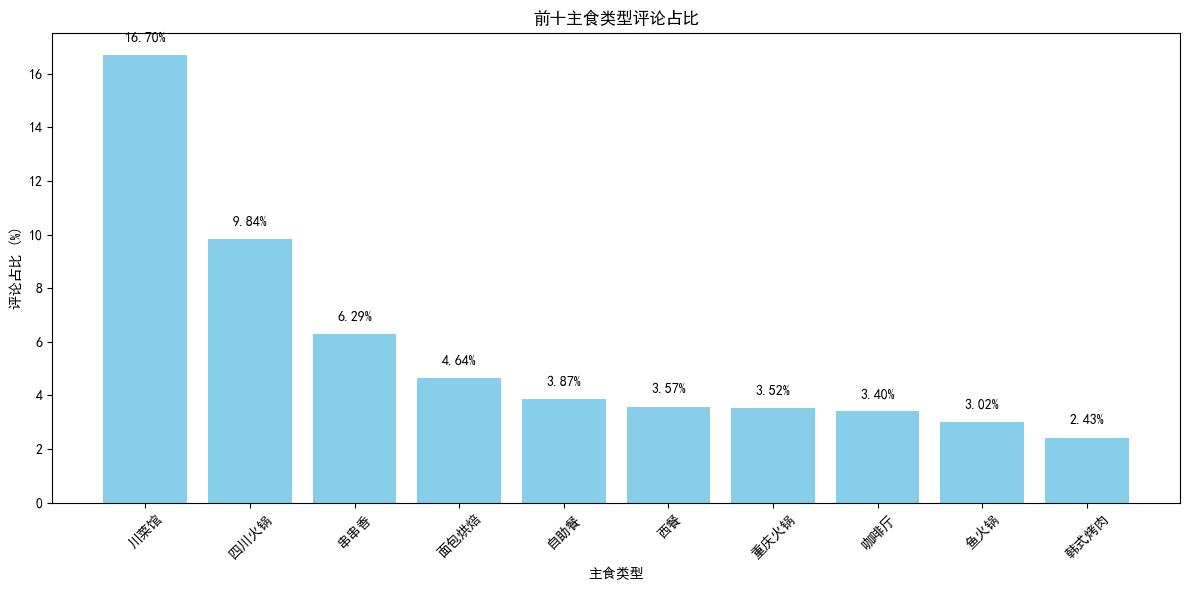

In [ ]:
main_food_counts = df.groupby('主食')['评论'].sum().reset_index()

total_comments = main_food_counts['评论'].sum()

main_food_counts['占比'] = main_food_counts['评论'] / total_comments

main_food_counts = main_food_counts.sort_values(by='占比', ascending=False)

print(main_food_counts)
top_10_main_food = main_food_counts.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_main_food['主食'], top_10_main_food['占比'] * 100, color='skyblue')

for i, val in enumerate(top_10_main_food['占比']):
    plt.text(i, val * 100 + 0.5, f'{val*100:.2f}%', ha='center')

plt.xlabel('主食类型')
plt.ylabel('评论占比 (%)')
plt.title('前十主食类型评论占比')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

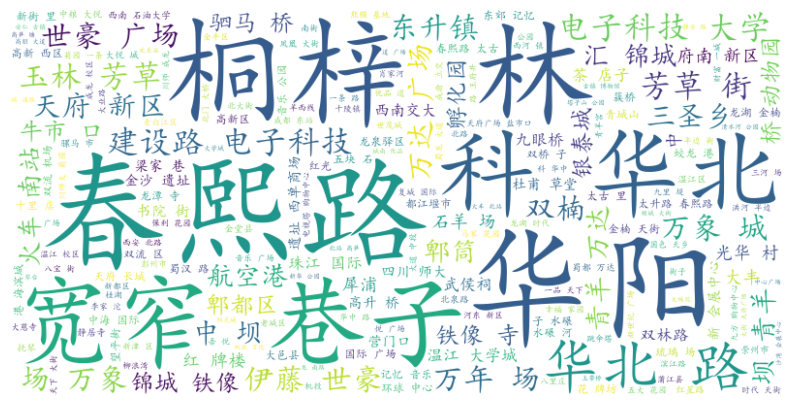

In [ ]:
stop_words_file = "stop_word.txt"
with open(stop_words_file, 'r', encoding='utf-8') as file:
    custom_stop_words = set([word.strip() for word in file.readlines()])


df['商圈地点'] = df['商圈地点'].fillna('')
text = ' '.join(df['商圈地点']).lower()

words = jieba.lcut(text)

filtered_words = [word for word in words if word not in custom_stop_words]

filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path="simkai.ttf").generate(filtered_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [116]:
cookies={
  "fspop": "test",
  "_lxsdk_cuid": "18e840a0078c8-0b7c5e936ea987-26001a51-13c680-18e840a0079c8",
  "_lxsdk": "18e840a0078c8-0b7c5e936ea987-26001a51-13c680-18e840a0079c8",
  "_hc.v": "b7d45eeb-9188-2a9a-c0f7-c87565145657.1711612232",
  "Hm_lvt_602b80cf8079ae6591966cc70a3940e7": "1711612233",
  "_lx_utm": "utm_source%3DBaidu%26utm_medium%3Dorganic",
  "cy": "8",
  "cye": "chengdu",
  "s_ViewType": "10",
  "WEBDFPID": "0x48z3z89w105y38058yz2z4v6y5848381v159zxx8w9795889y17x70-2026972283301-1711612283301CQKOGWSfd79fef3d01d5e9aadc18ccd4d0c95073548",
  "qruuid": "cd3accca-81a9-42b2-bc20-41910e373511",
  "dplet": "cee45729a031b16a47ec53b438264d99",
  "dper": "0202d024488a8139cda0049f04c8c1cac1c70bd70caaf0fc47021f8cdf5ce05b5ad7f1c129c442a404faa02b58a8b795cbe55d58fba9f9daa9b000000000fa1e00002ad66f0acd459cc5c8e0321f54965ceba20c0268d771e7d54841115d167e36d7c1b04d85b97b70938f9d84259a76b1ad",
  "ll": "7fd06e815b796be3df069dec7836c3df",
  "ua": "%E7%82%B9%E5%B0%8F%E8%AF%848793679062",
  "ctu": "b764f0d09af3d6815ec1347f5abe8697a733ac86ed70e90757f954c1c642f2d0",
  "Hm_lpvt_602b80cf8079ae6591966cc70a3940e7": "1711612479",
  "_lxsdk_s": "18e840a0079-400-0f9-384%7C%7C432"
}
headers = {
  "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
  "Accept-Language": "zh-CN,zh;q=0.9",
  "Cache-Control": "max-age=0",
  "Connection": "keep-alive",
  "Referer": "https://www.dianping.com/shop/G5AC3G5C4EYZ0ixU",
  "Sec-Fetch-Dest": "document",
  "Sec-Fetch-Mode": "navigate",
  "Sec-Fetch-Site": "same-origin",
  "Sec-Fetch-User": "?1",
  "Upgrade-Insecure-Requests": "1",
  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36",
  "sec-ch-ua-mobile": "?0"
}

In [ ]:
file_exists = os.path.isfile('comment.csv')
with open('comment.csv', mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(['评论'])
    for i in range(89, 150):
        url = f"https://www.dianping.com/shop/G5AC3G5C4EYZ0ixU/review_all/p{i}"
        response = requests.get(url=url, headers=headers,cookies=cookies)
        result = response.content.decode()
        comment_texts_hide = re.findall(r'<div class="review-words Hide">\s+(.*?)\s+<div class="less-words">', result, re.S)
        for idx, comment in enumerate(comment_texts_hide, start=1):
            comment_no_images = re.sub(r'<img.*?>', '', comment)
            cleaned_comment = comment_no_images.strip()
            if cleaned_comment:
                writer.writerow([cleaned_comment])
        comment_texts_no_hide = re.findall(r'<div class="review-words">\s+(.*?)\s+<div class="less-words">', result, re.S)
        for idx, comment in enumerate(comment_texts_no_hide, start=1):
            comment_no_images = re.sub(r'<img.*?>', '', comment)
            cleaned_comment = comment_no_images.strip()
            if cleaned_comment:
                writer.writerow([cleaned_comment])
        time.sleep(random.uniform(15, 20))
        print(i)

89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [4]:
data2 = pd.read_excel('comment_最终.xlsx')
data2

,评论
0,这家环境太好了，巴菲盛宴环球中心店，店面盛大，豪华，费用偏高，反正是品尝，值得打卡。&#x0...
1,我们选择这家婚礼堂作为我们爱情故事的见证者，而这一天绝对超出了我们的期待！首先，让我来说说菜...
2,芭菲盛宴自助产品，服务，环境嘿嘿，今天终于来了芭菲盛宴！这家自助餐厅真的是太赞了&#x20;...
3,我们一起7个人，还是挺划算哒，性价比挺高的啊，海鲜都是活的，个头也不小，品类也很丰富，就是门...
4,算是成都的老牌自助餐了，品种多，堂子大，性价比高。生日有优惠，小朋友1.2以上要收费，一家人...
...,...
1237,[服务铃]菜品：「牛排」「哈根达斯」「碳烤生蚝」「极品三文鱼拼」「椒盐富贵爬爬虾」「扇贝粉丝...
1238,🚈位置：孵化园地铁站下，楼下也有很多公交车站。很方便。&#x0A;&#x0A;[薄荷]环境：...
1239,5、6年前去过好几次，印象都很好，这次去还是一样的芭菲盛宴，菜品还可以，环境太老旧了，桌椅有...
1240,国庆节假期人比较多，中午去的我们基本满座。&#x0A;说说菜品吧：味道还是不错，烤生蚝、烤鸭...


In [ ]:
with open('stop_word.txt', 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file]
def remove_stopwords(text, stopwords):
    words = jieba.lcut(text)
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

data2['cleaned_comment'] = data2['评论'].apply(lambda x: remove_stopwords(x, stopwords))
data2

,评论,cleaned_comment,cluster
0,这家环境太好了，巴菲盛宴环球中心店，店面盛大，豪华，费用偏高，反正是品尝，值得打卡。&#x0...,这家 环境 太好了 巴菲 盛宴 环球 中心店 店面 盛大 豪华 费用 偏高 反正 品尝 值得...,3
1,我们选择这家婚礼堂作为我们爱情故事的见证者，而这一天绝对超出了我们的期待！首先，让我来说说菜...,选择 这家 婚礼 堂 爱情故事 见证者 超出 期待 说 菜品 质量 一道 菜 一场 美食 盛...,1
2,芭菲盛宴自助产品，服务，环境嘿嘿，今天终于来了芭菲盛宴！这家自助餐厅真的是太赞了&#x20;...,芭菲 盛宴 自助 产品 服务 环境 终于 芭菲 盛宴 这家 自助餐厅 真的 太赞 &# 服务...,1
3,我们一起7个人，还是挺划算哒，性价比挺高的啊，海鲜都是活的，个头也不小，品类也很丰富，就是门...,挺 划算 哒 性价比 挺 高 海鲜 个头 不小 品类 门口 门迎 冷冰冰 流程 术 不太 舒...,4
4,算是成都的老牌自助餐了，品种多，堂子大，性价比高。生日有优惠，小朋友1.2以上要收费，一家人...,算是 成都 老牌 自助餐 品种 堂子 性价比 高 生日 优惠 小朋友 1.2 收费 一家人 ...,0
...,...,...,...
1237,[服务铃]菜品：「牛排」「哈根达斯」「碳烤生蚝」「极品三文鱼拼」「椒盐富贵爬爬虾」「扇贝粉丝...,服务 铃 菜品 「 牛排 「 哈根达斯 「 碳 烤生 蚝 「 极品 三文鱼 拼 「 椒盐 富...,3
1238,🚈位置：孵化园地铁站下，楼下也有很多公交车站。很方便。&#x0A;&#x0A;[薄荷]环境：...,🚈 位置 孵化园 地铁站 楼下 公交车站 &# x0A &# x0A 薄荷 环境 奥克斯 三...,3
1239,5、6年前去过好几次，印象都很好，这次去还是一样的芭菲盛宴，菜品还可以，环境太老旧了，桌椅有...,年 前去 过好 几次 印象 芭菲 盛宴 菜品 环境 太老旧 桌椅 破损 看着 华丽 风 实用...,1
1240,国庆节假期人比较多，中午去的我们基本满座。&#x0A;说说菜品吧：味道还是不错，烤生蚝、烤鸭...,国庆节 假期 中午 满座 &# x0A 说 说 菜品 味道 不错 烤生 蚝 烤鸭 芝士 虾 ...,3


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['cleaned_comment'].apply(lambda x: analyzer.polarity_scores(x))

df['positive_score'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['neutral_score'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['negative_score'] = df['sentiment_scores'].apply(lambda x: x['neg'])

df[['cleaned_comment', 'positive_score', 'neutral_score', 'negative_score']]


NameError: name 'df' is not defined

In [ ]:
from textblob import TextBlob
df['sentiment'] = df['cleaned_comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['sentiment_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

df[['cleaned_comment', 'sentiment', 'sentiment_category']]

,cleaned_comment,sentiment,sentiment_category
0,这家 环境 太好了 巴菲 盛宴 环球 中心店 店面 盛大 豪华 费用 偏高 反正 品尝 值得...,0.0,neutral
1,选择 这家 婚礼 堂 爱情故事 见证者 超出 期待 说 菜品 质量 一道 菜 一场 美食 盛...,0.0,neutral
2,芭菲 盛宴 自助 产品 服务 环境 终于 芭菲 盛宴 这家 自助餐厅 真的 太赞 &# x2...,0.0,neutral
3,挺 划算 哒 性价比 挺 高 海鲜 个头 不小 品类 门口 门迎 冷冰冰 流程 术 不太 舒...,0.0,neutral
4,算是 成都 老牌 自助餐 品种 堂子 性价比 高 生日 优惠 小朋友 1.2 收费 一家人 ...,0.0,neutral
...,...,...,...
1237,服务 铃 菜品 「 牛排 「 哈根达斯 「 碳 烤生 蚝 「 极品 三文鱼 拼 「 椒盐 富...,0.0,neutral
1238,🚈 位置 孵化园 地铁站 楼下 公交车站 &# x0A &# x0A 薄荷 环境 奥克斯 三...,0.0,neutral
1239,年 前去 过好 几次 印象 芭菲 盛宴 菜品 环境 太老旧 桌椅 破损 看着 华丽 风 实用...,0.0,neutral
1240,国庆节 假期 中午 满座 &# x0A 说 说 菜品 味道 不错 烤生 蚝 烤鸭 芝士 虾 ...,0.0,neutral


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data2['cleaned_comment'])

feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_data = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

mean_tfidf = tfidf_data.mean()

top_tfidf_words = mean_tfidf.sort_values(ascending=False)[1:11]

print("Top 10 high-frequency words:")
print(top_tfidf_words)

Top 10 high-frequency words:
菜品    0.047217
不错    0.043696
服务    0.040544
环境    0.034076
海鲜    0.031493
芝士    0.031407
味道    0.030853
新鲜    0.029798
好吃    0.027941
排队    0.026907
dtype: float64


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from time import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
raw_data_dir = os.path.join(os.getcwd(), '\\data\\raw')
processed_data_dir = os.path.join(os.getcwd(), '\\data\\processed')
filename_temp = pd.Series(['分词效果'])
file_seg_effect = ''

In [28]:
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.7, min_df=0.005, stop_words=None,ngram_range=(1, 2))
X = vectorizer.fit_transform(data2['cleaned_comment'].values.astype('U'))

print("完成所耗费时间： %fs" % (time() - t0))
print("样本数量: %d, 特征数量: %d" % X.shape)
print('特征抽取完成！')

完成所耗费时间： 0.096220s
样本数量: 1242, 特征数量: 1078
特征抽取完成！


In [40]:
true_k = 2 #聚类数量

In [ ]:
labels = data2['cleaned_comment']
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=5)

print("对稀疏数据（Sparse Data） 采用 %s" % km)
t0 = time()
km.fit(X)
print("完成所耗费时间：%0.3fs" % (time() - t0))
print()

print("Homogeneity值: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness值: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure值: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index值: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient值: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

label_prediction = km.predict(X)   
label_prediction = list(label_prediction)

对稀疏数据（Sparse Data） 采用 KMeans(n_clusters=2, n_init=5)
完成所耗费时间：0.024s

Homogeneity值: 0.085
Completeness值: 1.000
V-measure值: 0.158
Adjusted Rand-Index值: 0.000
Silhouette Coefficient值: 0.025



In [ ]:
print("每个聚类的TOP关键词:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

if hasattr(vectorizer,'get_feature_names_out'):
    terms = vectorizer.get_feature_names_out()
elif hasattr(vectorizer,'get_feature_names'):
    terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("簇群 %d   " % (i+1), end='')
    print("该簇群所含文档占比为",'%.4f%%' % (int(label_prediction.count(i))/int(len(data2['cleaned_comment']))))
    print("簇群关键词：")
    wordset = []
    for ind in order_centroids[i, :20]:
        wordset.append(terms[ind].replace(' ',''))
    for word in wordset:
        print(' %s ' % word, end='')
    print('\n------------------------------------------------------------------------------------------------')

每个聚类的TOP关键词:
簇群 1   该簇群所含文档占比为 0.2979%
簇群关键词：
 x0a  服务  x0ax0a  环境  x0a服务  不错  薄荷  薄荷环境  服务服务  芝士  环境x0a  菜品  服务x0a  味道  x0a菜品  牛排  哈根达斯  感觉  好吃  海鲜 
------------------------------------------------------------------------------------------------
簇群 2   该簇群所含文档占比为 0.7021%
簇群关键词：
 菜品  不错  海鲜  味道  新鲜  排队  芝士  好吃  喜欢  自助餐  感觉  牛排  芭菲  性价比  特别  自助  小朋友  盛宴  环境  真的 
------------------------------------------------------------------------------------------------


In [43]:
labels=km.labels_.tolist()
#l =  km.fit_predict(X)  
svd = TruncatedSVD(n_components=2).fit(X)
datapoint = svd.transform(X)

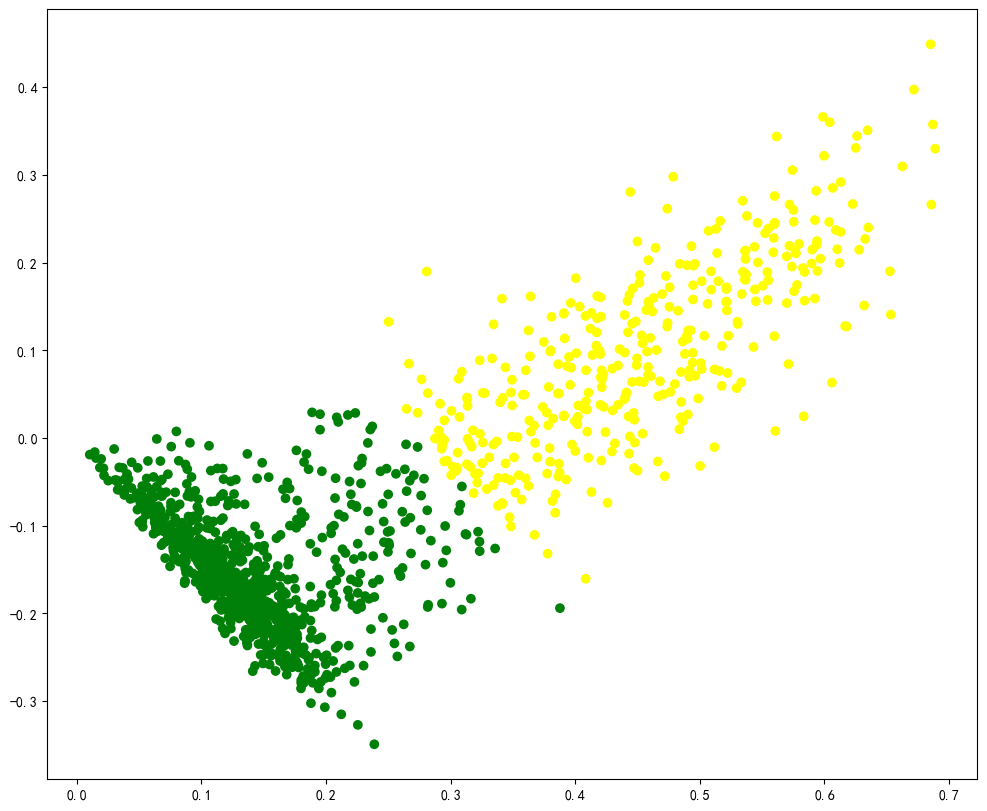

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 10))
label1 = [
'#FFFF00', '#008008', '#0000FF','#800080','#FFF5EE','#98FB98','#A0522D',
'#FF7F00','#FFC125','#FFFFFF','#FFFAFA','#FFF68F','#FFEFD5','#FFE4E1',
'#FFDEAD','#FFC1C1','#FFB90F','#FFA54F','#FF8C00','#C0FF3E','#FF6EB4',
'#FF4500','#FF3030','#8A2BE2','#87CEEB','#8470FF','#828282','#7EC0EE',
'#7CFC00','#7A8B8B','#79CDCD','#76EE00']

color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

plt.show()

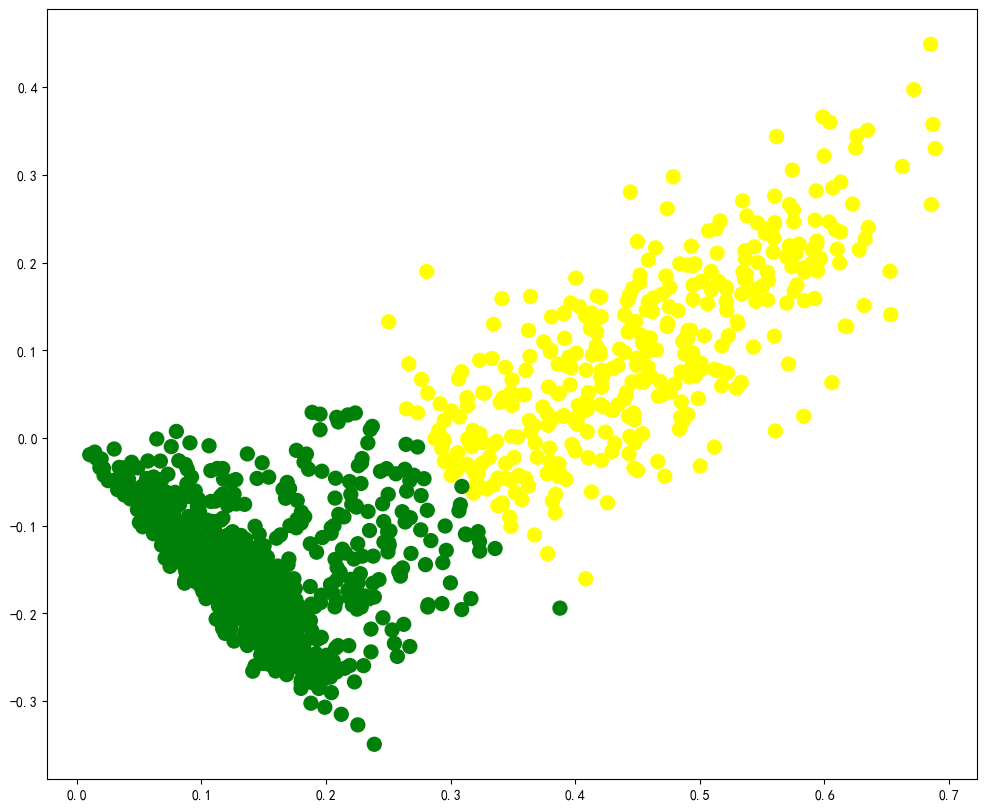

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 10))
label1 = [
    '#FFFF00', '#008008', '#0000FF','#800080','#FFF5EE','#98FB98','#A0522D',
    '#FF7F00','#FFC125','#FFFFFF','#FFFAFA','#FFF68F','#FFEFD5','#FFE4E1',
    '#FFDEAD','#FFC1C1','#FFB90F','#FFA54F','#FF8C00','#C0FF3E','#FF6EB4',
    '#FF4500','#FF3030','#8A2BE2','#87CEEB','#8470FF','#828282','#7EC0EE',
    '#7CFC00','#7A8B8B','#79CDCD','#76EE00'
]

color = [label1[i] for i in labels]

bubble_size = 100

plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color, s=bubble_size)

plt.show()


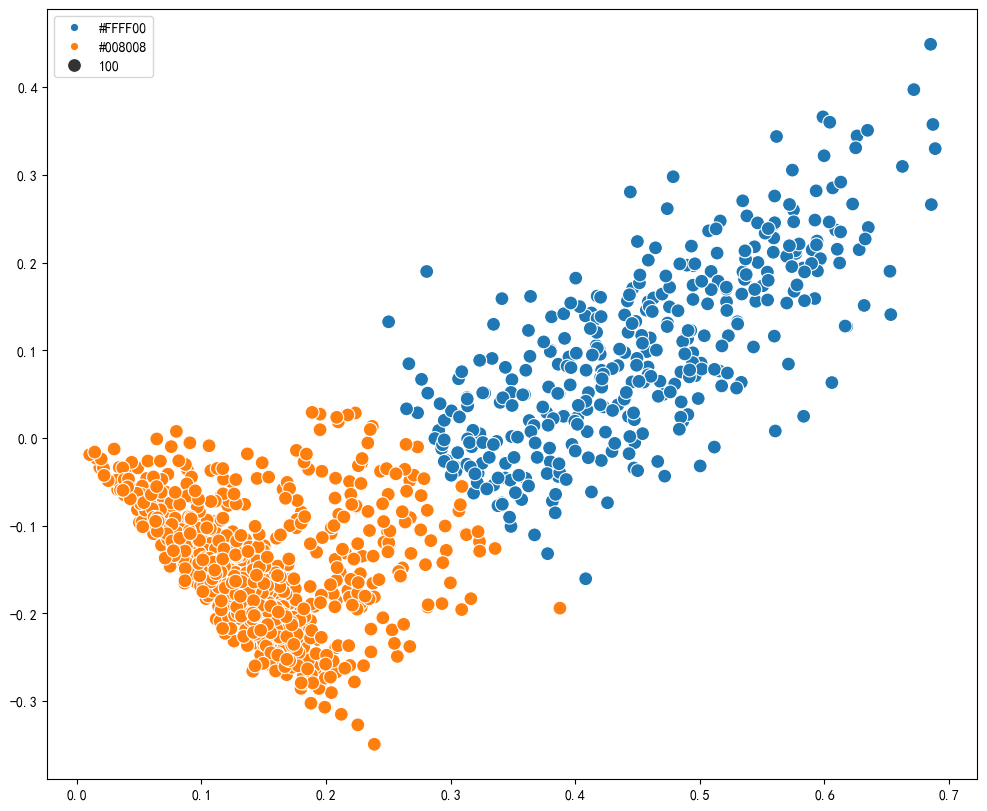

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
label1 = [
    '#FFFF00', '#008008', '#0000FF','#800080','#FFF5EE','#98FB98','#A0522D',
    '#FF7F00','#FFC125','#FFFFFF','#FFFAFA','#FFF68F','#FFEFD5','#FFE4E1',
    '#FFDEAD','#FFC1C1','#FFB90F','#FFA54F','#FF8C00','#C0FF3E','#FF6EB4',
    '#FF4500','#FF3030','#8A2BE2','#87CEEB','#8470FF','#828282','#7EC0EE',
    '#7CFC00','#7A8B8B','#79CDCD','#76EE00'
]

color = [label1[i] for i in labels]

bubble_size = 100

sns.scatterplot(x=datapoint[:, 0], y=datapoint[:, 1], hue=color, size=bubble_size, sizes=(bubble_size, bubble_size))

plt.show()
